<a href="https://colab.research.google.com/github/Mousoomi03/Ethical-AI-for-Social-Media-Monitoring/blob/main/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers datasets torch scikit-learn pandas

In [ ]:
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Step 1: Load datasets
labeled_data = pd.read_csv("labeled_data.csv", encoding="ISO-8859-1")
unlabeled_data = pd.read_csv("unlabeled_data.csv")

# **Reduce Dataset Size**
#labeled_data = labeled_data.sample(frac=0.2, random_state=42)  # Use 20% of labeled data
unlabeled_data = unlabeled_data.sample(n=500, random_state=42)  # Use only 500 samples for inference

# Step 2: Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)  # Binary classification

# Step 3: Create PyTorch Dataset
class EthicalDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Step 4: Split Labeled Data into Train & Eval
train_texts, eval_texts, train_labels, eval_labels = train_test_split(
    labeled_data["Comment"].tolist(),
    labeled_data["Label"].tolist(),
    test_size=0.2, random_state=42
)

train_dataset = EthicalDataset(train_texts, train_labels)
eval_dataset = EthicalDataset(eval_texts, eval_labels)

# Step 5: Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,  # Reduce training epochs
    weight_decay=0.01,
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Step 6: Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Step 7: Train the model
trainer.train()

# Step 8: Predict on Unlabeled Data
unlabeled_texts = unlabeled_data["Comment"].tolist()
unlabeled_dataset = EthicalDataset(unlabeled_texts)  # No labels needed for inference

predictions = trainer.predict(unlabeled_dataset)
pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1).tolist()

# Step 9: Save Results
unlabeled_data["Predicted_Label"] = pred_labels
unlabeled_data.to_csv("labeled_unlabeled_data.csv", index=False)

print("Predictions saved to labeled_unlabeled_data.csv!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not inten

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mousoomi (mousoomi-vellore-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.725030
2,0.690600,0.735990


Predictions saved to labeled_unlabeled_data.csv!


In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss

# Step 1: Load datasets
labeled_data = pd.read_csv("labeled_data.csv", encoding="ISO-8859-1")
unlabeled_data = pd.read_csv("unlabeled_data.csv", encoding="ISO-8859-1")
unlabeled_data = unlabeled_data.sample(n=500, random_state=42)
# Step 2: Check Dataset Balance BEFORE Splitting
print("Original Label Distribution:", labeled_data["Label"].value_counts())

# Step 3: Split Labeled Data into Train & Eval
train_texts, eval_texts, train_labels, eval_labels = train_test_split(
    labeled_data["Comment"].tolist(),
    labeled_data["Label"].tolist(),
    test_size=0.2, random_state=42, stratify=labeled_data["Label"]
)

# Check balance AFTER splitting
print("Train labels distribution:", np.bincount(train_labels))
print("Eval labels distribution:", np.bincount(eval_labels))

# Step 4: Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Step 5: Create PyTorch Dataset
class EthicalDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=128)
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Create PyTorch datasets
train_dataset = EthicalDataset(train_texts, train_labels)
eval_dataset = EthicalDataset(eval_texts, eval_labels)

# Step 6: Define Class Weights & Model (Using CPU)
class_weights = torch.tensor([1.0, 1.0])  # No `.to("cuda")`

class WeightedRoberta(RobertaForSequenceClassification):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Initialize model (Using CPU)
model = WeightedRoberta.from_pretrained("roberta-base", num_labels=2)  # No `.to("cuda")`

# Step 7: Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,  # Increased epochs
    weight_decay=0.01,
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Step 8: Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Step 9: Train the model
trainer.train()

# Step 10: Predict on Unlabeled Data
unlabeled_texts = unlabeled_data["Comment"].tolist()
unlabeled_dataset = EthicalDataset(unlabeled_texts)  # No labels needed for inference

predictions = trainer.predict(unlabeled_dataset)
pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1).tolist()

# Step 11: Save Results
unlabeled_data["Predicted_Label"] = pred_labels
unlabeled_data.to_csv("labeled_unlabeled_data.csv", index=False)

print("Predictions saved to labeled_unlabeled_data.csv!")


Original Label Distribution: Label
1    30
0    30
Name: count, dtype: int64
Train labels distribution: [24 24]
Eval labels distribution: [6 6]


Some weights of WeightedRoberta were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.703592
2,0.758000,0.662270
3,0.758000,0.547546


Epoch,Training Loss,Validation Loss
1,No log,0.703592
2,0.758000,0.662270
3,0.758000,0.547546
4,0.572400,0.474064


Predictions saved to labeled_unlabeled_data.csv!


Some weights of WeightedRoberta were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.696277
2,No log,0.683242
3,No log,0.664488
4,0.697100,0.614335
5,0.697100,0.521725
6,0.697100,0.437976
7,0.505000,0.389913
8,0.505000,0.364650



**Model Performance Metrics:**
Accuracy: 0.9167
Precision: 1.0000
Recall: 0.8333
F1-score: 0.9091

Confusion Matrix:
[[6 0]
 [1 5]]


<ipython-input-5-742b48d72a5b>:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics_values, ax=axes[1], palette="viridis")


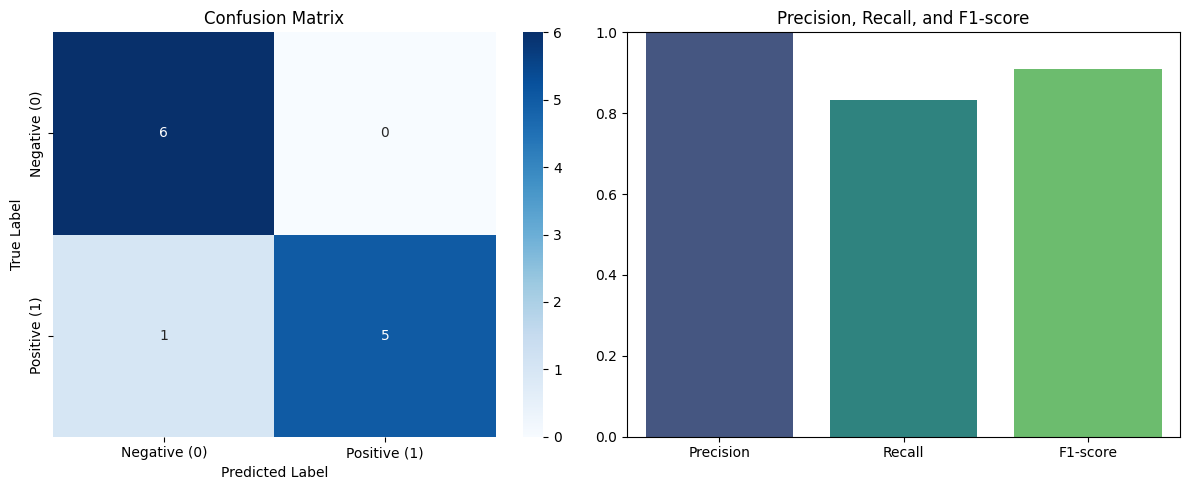

In [ ]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import random

#Fix random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

#Tokenizer Setup
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

#Class Weights (Auto-adjusted)
unique, counts = np.unique(eval_labels, return_counts=True)
class_weights = torch.tensor(1.0 / counts, dtype=torch.float32)

#Model Setup
class WeightedRoberta(RobertaForSequenceClassification):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

model = WeightedRoberta.from_pretrained("roberta-base", num_labels=2)

#Training Arguments (Optimized)
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=16,  # Increased batch size
    per_device_eval_batch_size=16,
    num_train_epochs=8,  # More training time
    weight_decay=0.005,  # Reduce overfitting
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    lr_scheduler_type="linear",  # Helps in convergence
    warmup_ratio=0.1,  # Helps avoid initial instability
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

#Train Model
trainer.train()

#Evaluate Model Performance
eval_predictions = trainer.predict(eval_dataset)
eval_preds = torch.argmax(torch.tensor(eval_predictions.predictions), dim=1).tolist()

#Calculate Metrics
accuracy = accuracy_score(eval_labels, eval_preds)
precision, recall, f1, _ = precision_recall_fscore_support(eval_labels, eval_preds, average="binary")
conf_matrix = confusion_matrix(eval_labels, eval_preds)

#Print Metrics
print("\n**Model Performance Metrics:**")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

#Plot Performance Metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#1.Confusion Matrix Heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative (0)", "Positive (1)"],
            yticklabels=["Negative (0)", "Positive (1)"], ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

#2.Precision, Recall, F1 Bar Chart
metrics_names = ["Precision", "Recall", "F1-score"]
metrics_values = [precision, recall, f1]
sns.barplot(x=metrics_names, y=metrics_values, ax=axes[1], palette="viridis")
axes[1].set_title("Precision, Recall, and F1-score")
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


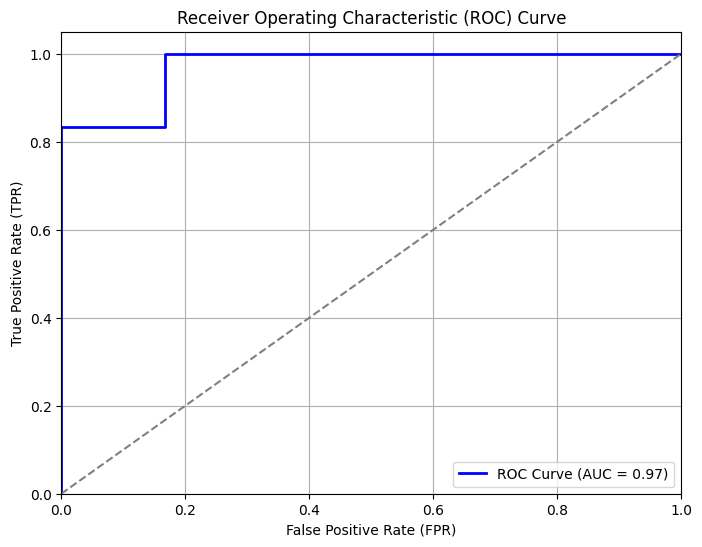

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities for the positive class (1)
eval_probs = torch.softmax(torch.tensor(eval_predictions.predictions), dim=1)[:, 1].numpy()

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(eval_labels, eval_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


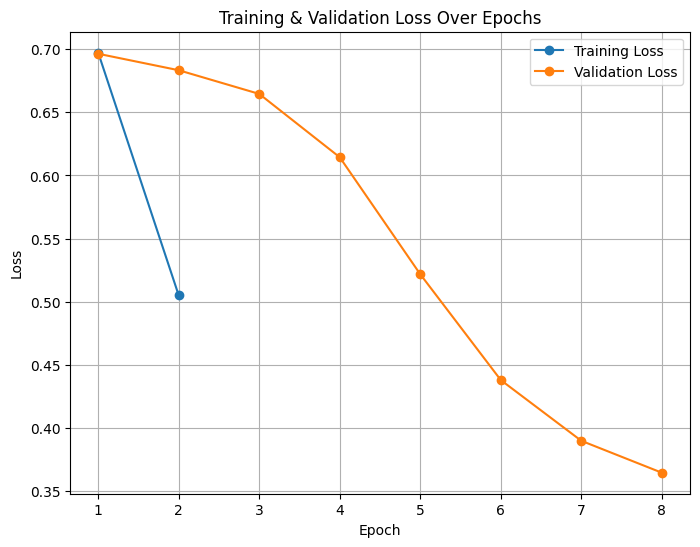

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation loss
train_losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
val_losses = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Plot Training & Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


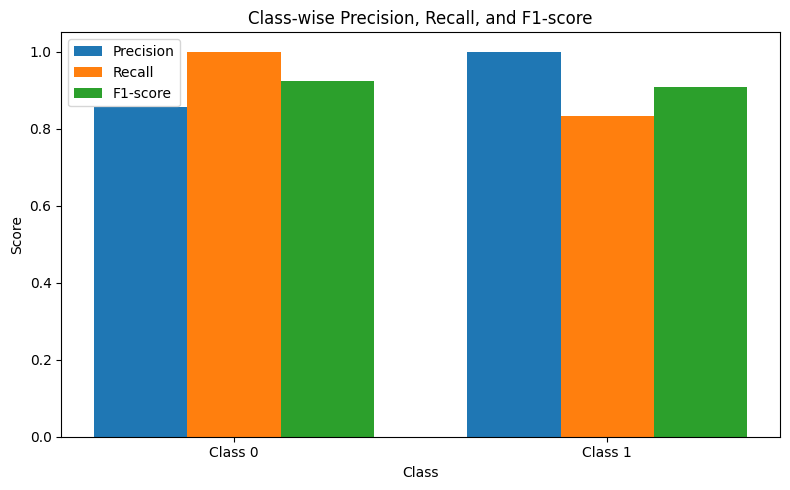

In [ ]:
precision_cls, recall_cls, f1_cls, _ = precision_recall_fscore_support(eval_labels, eval_preds, average=None)

labels = ["Class 0", "Class 1"]
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.25
ax.bar(x, precision_cls, bar_width, label='Precision')
ax.bar(x + bar_width, recall_cls, bar_width, label='Recall')
ax.bar(x + 2*bar_width, f1_cls, bar_width, label='F1-score')

ax.set_xlabel("Class")
ax.set_ylabel("Score")
ax.set_title("Class-wise Precision, Recall, and F1-score")
ax.set_xticks(x + bar_width)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()


<ipython-input-10-5f6f1f297b55>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pred_labels, palette="pastel")


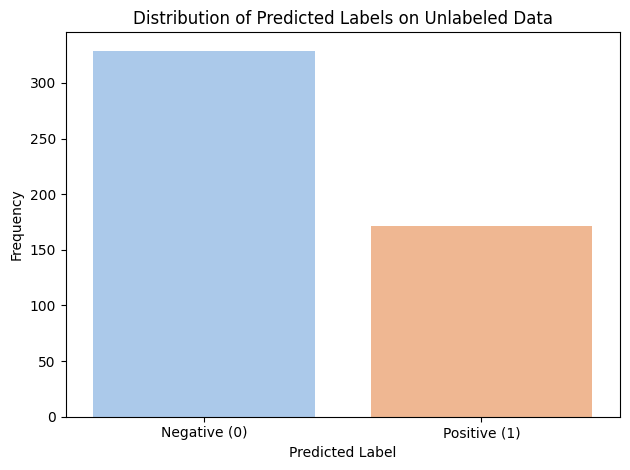

In [ ]:
sns.countplot(x=pred_labels, palette="pastel")
plt.title("Distribution of Predicted Labels on Unlabeled Data")
plt.xlabel("Predicted Label")
plt.ylabel("Frequency")
plt.xticks([0, 1], ["Negative (0)", "Positive (1)"])
plt.tight_layout()
plt.show()


Epoch,Training Loss,Validation Loss
1,No log,0.336389
2,No log,1.078457
3,No log,0.536191
4,0.107900,0.539236
5,0.107900,0.536925
6,0.107900,0.639457
7,0.002000,0.645532
8,0.002000,0.645603


Epoch,Training Loss,Validation Loss
1,No log,0.317289
2,No log,0.247176
3,No log,0.424380
4,0.007700,0.578217
5,0.007700,0.661172
6,0.007700,0.697986
7,0.000600,0.712943
8,0.000600,0.717360


Epoch,Training Loss,Validation Loss
1,No log,0.428724
2,No log,0.604658
3,No log,0.608457
4,0.004800,0.615090
5,0.004800,0.569584
6,0.004800,0.626367
7,0.010800,0.651082
8,0.010800,0.657000


Epoch,Training Loss,Validation Loss
1,No log,0.457446
2,No log,0.537574
3,No log,0.586257
4,0.001700,0.607585
5,0.001700,0.627625
6,0.001700,0.642109
7,0.000500,0.648587
8,0.000500,0.650351


Epoch,Training Loss,Validation Loss
1,No log,0.473015
2,No log,0.527933
3,No log,0.580188
4,0.001500,0.600306
5,0.001500,0.622383
6,0.001500,0.640319
7,0.000500,0.650600
8,0.000500,0.654011


Epoch,Training Loss,Validation Loss
1,No log,0.491936
2,No log,0.542019
3,No log,0.576639
4,0.001300,0.592071
5,0.001300,0.600169
6,0.001300,0.610678
7,0.000400,0.618405
8,0.000400,0.621365


Epoch,Training Loss,Validation Loss
1,No log,0.505982
2,No log,0.552951
3,No log,0.603580
4,0.001100,0.633624
5,0.001100,0.650055
6,0.001100,0.661340
7,0.000400,0.667761
8,0.000400,0.669949


Epoch,Training Loss,Validation Loss
1,No log,0.509644
2,No log,0.527191
3,No log,0.565262
4,0.000900,0.595759
5,0.000900,0.617678
6,0.000900,0.633467
7,0.000400,0.641746
8,0.000400,0.644674


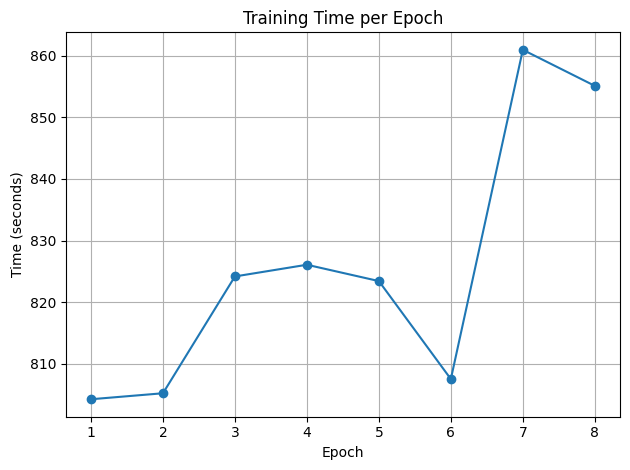

In [ ]:
import time

times = []

for epoch in range(training_args.num_train_epochs):
    start = time.time()
    trainer.train()
    end = time.time()
    times.append(end - start)

plt.plot(range(1, len(times) + 1), times, marker='o')
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Baseline Models: Logistic Regression and TF-IDF + SVM
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Load labeled data
df = pd.read_csv("labeled_data.csv", encoding="ISO-8859-1")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df["Comment"], df["Label"], test_size=0.2, random_state=42, stratify=df["Label"]
)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 1. Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_preds = lr_model.predict(X_test_tfidf)
lr_acc = accuracy_score(y_test, lr_preds)
print("🔹 Logistic Regression Accuracy:", round(lr_acc * 100, 2), "%")
print(classification_report(y_test, lr_preds))

# 2. TF-IDF + SVM
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
svm_preds = svm_model.predict(X_test_tfidf)
svm_acc = accuracy_score(y_test, svm_preds)
print("🔹 TF-IDF + SVM Accuracy:", round(svm_acc * 100, 2), "%")
print(classification_report(y_test, svm_preds))


🔹 Logistic Regression Accuracy: 75.0 %
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.71      0.83      0.77         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

🔹 TF-IDF + SVM Accuracy: 75.0 %
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.71      0.83      0.77         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

